## Homework 4

Use this notebook as a starter

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

Data:

- https://github.com/gastonstat/CreditScoring
- Also available [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv)

In [2]:
!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv

--2021-10-02 12:33:24--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182489 (178K) [text/plain]
Saving to: ‘CreditScoring.csv.9’

CreditScoring.csv.9 100%[===================>] 178.21K  56.7KB/s    in 3.1s    

2021-10-02 12:33:28 (56.7 KB/s) - ‘CreditScoring.csv.9’ saved [182489/182489]



## Preparation 

We'll talk about this dataset in more details in week 6. But for now, use the following code to get started

In [3]:
df = pd.read_csv('CreditScoring.csv')
df.columns = df.columns.str.lower()

Some of the features are encoded as numbers. Use the following code to de-code them:

In [4]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

Prepare the numerical variables:

In [5]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status

In [6]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [7]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

## Your code

What are the categorical variables? What are the numerical?

In [8]:
print(df.dtypes.unique())

[dtype('int64') dtype('O')]


In [9]:
cat_feats = list(df.columns[df.dtypes=='object'])
num_feats = list(df.columns[df.dtypes=='int64'])
num_feats.remove('default')

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`

In [10]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.default.values
y_val = df_val.default.values
y_test = df_test.default.values

del df_train['default']
del df_val['default']
del df_test['default']

print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(2672, 13)
(891, 13)
(891, 13)


## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the default variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [11]:
from sklearn.metrics import roc_auc_score

In [12]:
for feature in num_feats:
    auc = roc_auc_score(y_train,df_train[feature])
    
    if auc < 0.5:
        df_train[feature] = -df_train[feature]
    print(feature,auc)

seniority 0.2906221375508058
time 0.5608662489595051
age 0.4267066727500061
expenses 0.4990815782782989
income 0.31799333386736695
assets 0.35139574328771983
debt 0.49521703242164505
amount 0.5910773431595518
price 0.5043329862114843


Which numerical variable (among the following 4) has the highest AUC?

- seniority  
- **time** <==
- income
- debt

## Training the model

From now on, use these columns only:

```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [15]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression


feats = ['seniority', 'income', 'assets', 'records', 'job', 'home']
dv = DictVectorizer(sparse=False)

train_dict = df_train[feats].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[feats].to_dict(orient='records')
X_val = dv.transform(val_dict)

mod = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
mod.fit(X_train,y_train)

y_pred = mod.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred).round(3)

0.52

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- **0.512** <==
- 0.612
- 0.712
- 0.812

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

In [16]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    p = tp / (tp + fp)
    r = tp / (tp + fn)
    
    scores.append((t, p, r))

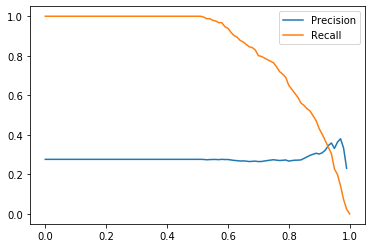

In [17]:
columns = ['threshold', 'precision', 'recall']
df_scoresPR = pd.DataFrame(scores, columns=columns)

plt.plot(df_scoresPR.threshold, df_scoresPR['precision'], label='Precision')
plt.plot(df_scoresPR.threshold, df_scoresPR['recall'], label='Recall')
plt.legend()

At which threshold precision and recall curves intersect?

* 0.2
* 0.4
* 0.6
* **0.8** <==

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

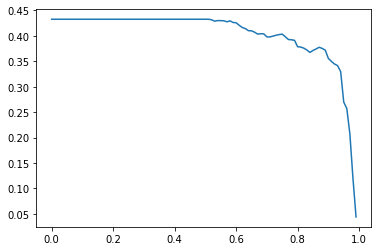

In [18]:
scores = []
for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    p = tp / (tp + fp)
    r = tp / (tp + fn)
    
    f1 = 2*(p*r)/(p+r)
    
    scores.append((t, f1))
    
df_scoresF1 = pd.DataFrame(scores, columns=['threshold', 'f1'])

plt.plot(df_scoresF1.threshold, df_scoresF1['f1'])

At which threshold F1 is maximal?

- **0.1** <==
- 0.3
- 0.5
- 0.7

## Question 5


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


In [19]:
def train(df_train, y_train, c=1.0):
    dicts = df_train[feats].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=c, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [20]:
def predict(df, dv, model):
    dicts = df[feats].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [30]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5,shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.default.values
    y_val = df_val.default.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.814 +- 0.015


How large is standard devidation of the scores across different folds?

- 0.001
- **0.014** <==
- 0.09
- 0.14

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std

In [29]:
for C in [0.01, 0.1, 1, 10]:
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.default.values
        y_val = df_val.default.values

        dv, model = train(df_train, y_train, c=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=0.01 0.808 +- 0.012
C=0.1 0.813 +- 0.014
C=1 0.814 +- 0.015
C=10 0.814 +- 0.015


Which C leads to the best mean score?

- 0.01
- 0.1
- **1** <==
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

## Submit the results

Submit your results here: https://forms.gle/e497sR5iB36mM9Cs5

It's possible that your answers won't match exactly. If it's the case, select the closest one.

## Deadline

The deadline for submitting is 04 October 2021, 17:00 CET. After that, the form will be closed.